#*Shannon’s entropy and Its Generalizations towards Statistics, Reliability and Information Science during 1948-2018*

## Report on the work done. Zakharov, Marin, Chernyy.

[Paper link](https://arxiv.org/pdf/1901.09779.pdf)

## Estimation of $H(\xi)$

$H(\xi)=-\int_{-\infty}^{\infty} f(\xi) \log _{2} f(\xi) d x$

In [ ]:
import numpy as np
import numpy.linalg as nla
import scipy
import scipy.stats
import pandas as pd
from tqdm import tqdm 
import matplotlib.pyplot as plt
from scipy.stats import norm

## Data and their real entropy value

In [ ]:
n = 1000
X_normal = np.random.normal(0, 1, n)
X_uniform = np.random.uniform(0, 1, n)
X_exponential = np.random.exponential(1, n)

In [ ]:
def real_H_normal(sigma):
    return np.log(sigma * np.sqrt(2 * np.pi * np.e))
def real_H_uniform(a, b):
    return np.log(b - a)
def real_H_exponential(lmbda):
    return 1 - np.log(lmbda)
def real_H_laplace(b):
	return 1 + np.log(2 * b)
def real_H_chi_squared(k):
	return np.log(2 * gamma(k/2)) - (1 - k/2) * digamma(k/2) + k/2
def real_H_gamma(k, theta):
	return np.log(theta * gamma(k)) + (1 - k) * digamma(k) + k

print("Entropy for N(0, 1) equals to", real_H_normal(1))
print("Entropy for U(0, 1) equals to", real_H_uniform(0, 1))
print("Entropy for Exp(1) equals to", real_H_exponential(1))

Entropy for N(0, 1) equals to 1.4189385332046727
Entropy for U(0, 1) equals to 0.0
Entropy for Exp(1) equals to 1.0


## Finding optimal h for kernel and histogram estimates using cv

[ON THE ESTIMATION OF ENTROPY(1991)](https://www.ism.ac.jp/editsec/aism/pdf/045_1_0069.pdf)

In [ ]:
# Histogram estimate

def cross_val_hist(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = int((sample_max - sample_min) / h)
    summ = 0
    deltas = [[sample_min + (i - 1) * h, sample_min + i * h] for i in range(1, bins+1)]
    
    N = []
    
    for l, r in deltas:
        nu = np.sum([1 if l <= v <= r else 0 for v in sample])
        summ += (nu / n)**2
        
        N.append(nu)
    
    return 2 / ((n - 1) * h) - (n + 1) / ((n - 1) * h) * summ, N

**Kernel**: $\hat{f}_{i}(\mathbf{x})=\frac{1}{(n-1) h} \sum_{j(\neq i)=1}^{n} k\left(\frac{\mathbf{x}-\mathbf{X}_{j}}{h}\right)$

In [ ]:
# Kernel estimate

def gaussian(u):
    return np.exp(-u ** 2 / 2.0) / np.sqrt(2.0 * np.pi)

def gaussian_star(u):
    return np.exp(-u ** 2 / 4.0) / (2.0 * np.sqrt(np.pi))

def cross_val_gaus(sample, h):
    n = len(sample)
    J_sum = 0
    for i in range(n):
        for j in range(n):
            u = (sample[i] - sample[j]) / h
            J_sum += gaussian_star(u) - 2.0 * gaussian(u)
    J_sum /= (h * n ** 2)
    J_sum += 2.0 * gaussian(0) / (n * h)
    return J_sum

In [ ]:
h_hist_list = np.logspace(-1, 1, 100)

In [ ]:
cv_hist_normal = [cross_val_hist(X_normal, hi)[0] for hi in h_hist_list]
h_hist_normal = h_hist_list[np.argmin(cv_hist_normal)]

cv_hist_uniform = [cross_val_hist(X_uniform, hi)[0] for hi in h_hist_list]
h_hist_uniform = h_hist_list[np.argmin(cv_hist_uniform)]

cv_hist_exponential = [cross_val_hist(X_exponential, hi)[0] for hi in h_hist_list]
h_hist_exponential = h_hist_list[np.argmin(cv_hist_exponential)]

In [ ]:
h_kernel_list = np.logspace(-1, 1, 10)

In [ ]:
cv_kernel_normal = [cross_val_gaus(X_normal, hi) for hi in h_kernel_list]
h_kernel_normal = h_kernel_list[np.argmin(cv_kernel_normal)]

cv_kernel_uniform = [cross_val_gaus(X_uniform, hi) for hi in h_kernel_list]
h_kernel_uniform = h_kernel_list[np.argmin(cv_kernel_uniform)]

cv_kernel_exponential = [cross_val_gaus(X_exponential, hi) for hi in h_kernel_list]
h_kernel_exponential = h_kernel_list[np.argmin(cv_kernel_exponential)]

In [ ]:
print("Optimal histogram bandwidth for N(0, 1) equals to", round(h_hist_normal, 3))
print("Optimal histogram bandwidth for U(0, 1) equals to", round(h_hist_uniform, 3))
print("Optimal histogram bandwidth for Exp(1) equals to", round(h_hist_exponential, 3))

Optimal histogram bandwidth for N(0, 1) equals to 0.242
Optimal histogram bandwidth for U(0, 1) equals to 0.11
Optimal histogram bandwidth for Exp(1) equals to 0.159


In [ ]:
print("Optimal kernel bandwidth for N(0, 1) equals to", round(h_kernel_normal, 3))
print("Optimal kernel bandwidth for U(0, 1) equals to", round(h_kernel_uniform, 3))
print("Optimal kernel bandwidth for Exp(1) equals to", round(h_kernel_exponential, 3))

Optimal kernel bandwidth for N(0, 1) equals to 0.167
Optimal kernel bandwidth for U(0, 1) equals to 0.1
Optimal kernel bandwidth for Exp(1) equals to 0.1


In [ ]:
def draw_bandwidth(cv_hist, cv_kernel, h_hist, h_kernel):
    z_, ax = plt.subplots(figsize=(15, 5), ncols=2, nrows=1, sharey=True)

    ax[0].plot(h_hist_list, cv_hist, alpha=0.9)
    ax[0].axhline(min(cv_hist), c='r', linestyle='--', alpha=0.8, label=r'${\bf J}_{hist}=$'f'{min(cv_hist):.4f}')
    ax[0].plot(h_hist, min(cv_hist), 'ro', markersize='5')

    ax[0].set_xscale("log")
    ax[0].set_xlabel(r"h, bandwidth")
    ax[0].set_ylabel("Risk surrogate estimate")
    ax[0].set_title(r"${\it Histogram}$")
    ax[0].legend(prop={'size': 15}, loc='upper right')
    ax[0].grid()

    ax[1].plot(h_kernel_list, cv_kernel, alpha=0.9)
    ax[1].axhline(min(cv_kernel), c='r', linestyle='--', alpha=0.8, label=r'${\bf J}_{kernel}=$'f'{min(cv_kernel):.4f}')
    ax[1].plot(h_kernel, min(cv_kernel), 'ro', markersize='5')

    ax[1].set_xscale("log")
    ax[1].set_xlabel(r"h, bandwidth")
    ax[1].set_title(r"${\it Gaussian \quad kernel}$")
    ax[1].legend(prop={'size': 15}, loc='upper right')
    ax[1].grid()

    plt.tight_layout()
    plt.show()

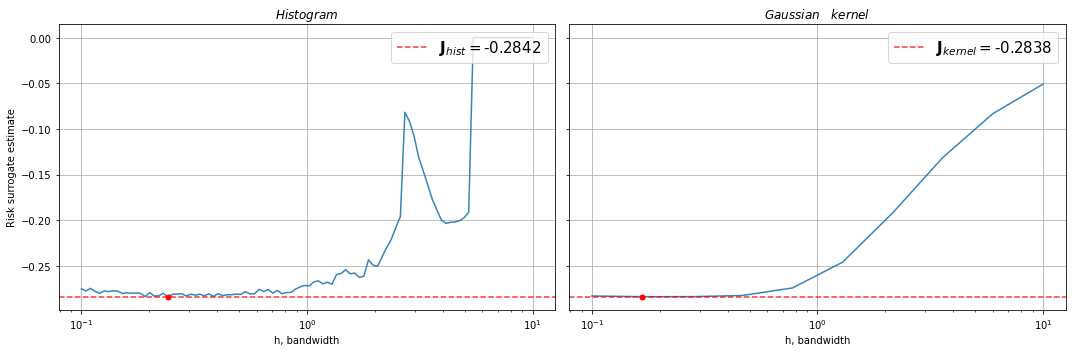

In [ ]:
draw_bandwidth(cv_hist_normal, cv_kernel_normal, h_hist_normal, h_kernel_normal)

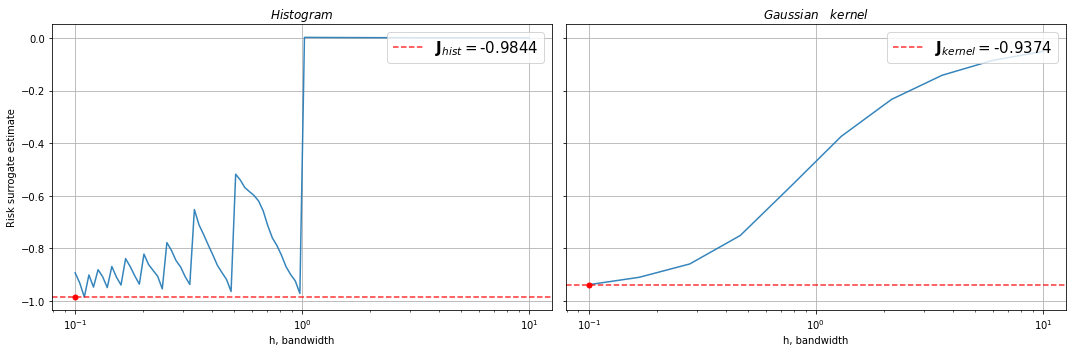

In [ ]:
draw_bandwidth(cv_hist_uniform, cv_kernel_uniform, h_kernel_uniform, h_kernel_uniform)

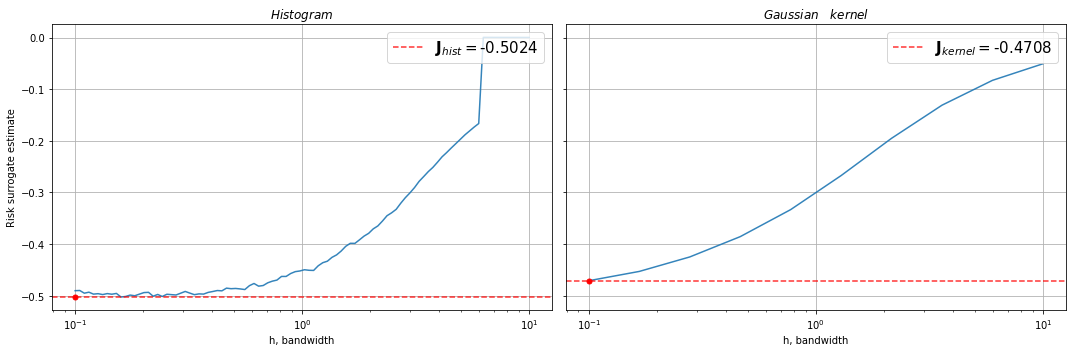

In [ ]:
draw_bandwidth(cv_hist_exponential, cv_kernel_exponential, h_kernel_exponential, h_kernel_exponential)

## Estimates for $\hat{H}(\xi)$ using asymptotic normality(MLE) & bootstrap

If $\sigma^{2}=\int f(\log f)^{2}-H^{2}<\infty$, then our estimators $\bar{H}$ is root- $n$ consistent for $H$, and in fact $n^{1 / 2}(\bar{H}-H)$ is asymptotically normal $\mathcal{N\left(0, \sigma^{2}\right)}$.

Here:

$\bar{H}= {1 \over n} \sum \log f\left(X_{i}\right)$ for both *histogram* and *kernel*.

[page 73](https://www.ism.ac.jp/editsec/aism/pdf/045_1_0069.pdf)

$\hat{H}= {1 \over n} \sum N_{i} \log \left\{{N_{i} \over n h}\right\}= {1 \over n} \sum N_{i} \left[\log N_{i}-\log \left(n h\right)\right]$

$N_i \equiv$ number of elements in $B_i$*-th* bin.

In [ ]:
# Histogram

def get_hist_estimate(x, h):
    N = np.array(cross_val_hist(x, h)[1])

    N = N[np.nonzero(N)]

    return 1 / x.shape[0] * np.sum(N * (np.log(N / (x.shape[0] * h))))

$\hat{f}_{i}(\mathbf{x})=\frac{1}{(n-1) h} \sum_{j(\neq i)=1}^{n} k\left(\frac{\mathbf{x}-\mathbf{X}_{j}}{h}\right)$

In [ ]:
def get_density(x, index, h, samples):
    n = samples.shape[0]

    mask = np.ones(n, dtype=np.bool_)
    mask[index] = False

    sum = 0.

    for i, s in enumerate(samples[mask]):
        sum += gaussian((x - s) / h)
        
    return 1 / ((n - 1) * h) * sum

[page 85](https://www.ism.ac.jp/editsec/aism/pdf/045_1_0069.pdf)

$\hat{H}=n^{-1} \sum_{i=1}^{n} \log \hat{f}_{i}\left(X_{i}\right)$

In [ ]:
# Kernel

def get_kernel_estimate(x, h):
    densities = [get_density(s, i, h, x) for i, s in enumerate(x)]
    
    return np.sum(np.log(densities)) / x.shape[0]

In [ ]:
def get_mean(f):
    return np.sum(np.log(f)) / len(f)

def get_sigma(f, H_val):
    return np.sqrt((np.sum(f * np.power(np.log(f), 2)) - H_val**2) / len(f))

### ***Bootstrap CI:***

In [ ]:
from numpy.random import choice
def get_bootstrap_hist_var(sample, h_list, n_runs):
    
    boot_sample = []
    n = sample.shape[0]
    
    for _ in range(n_runs):
        smp = choice(a=sample, size=n, replace=True)
        
        cv = [cross_val_hist(smp, hi)[0] for hi in h_list]
        
        h = h_list[np.argmin(cv)] 
        
        boot_sample.append(get_hist_estimate(smp, h))

    mean = np.mean(boot_sample)
    
    return np.var(boot_sample)

In [ ]:
def get_bootstrap_kernel_var(sample, h_list, n_runs):
    
    boot_sample = []
    n = sample.shape[0]
    
    for _ in range(n_runs):
        smp = choice(a=sample, size=n, replace=True)
        
        cv = [cross_val_gaus(smp, hi) for hi in h_list]
        h = h_list[np.argmin(cv)] 
        
        boot_sample.append(get_kernel_estimate(smp, h))
    

    mean = np.mean(boot_sample)
    
    return np.var(boot_sample)

In [ ]:
def get_bootstrap_hist_ci(sample, estimate, h_list, alpha, n_runs=100):    
    z = norm.ppf(1 - alpha / 2)
    error = np.sqrt(get_bootstrap_hist_var(sample, h_list, n_runs))
    
    return estimate, (estimate - z * error, estimate + z * error)

In [ ]:
def get_bootstrap_kernel_ci(sample, estimate, h_list, alpha, n_runs=100):    
    z = norm.ppf(1 - alpha / 2)
    error = np.sqrt(get_bootstrap_kernel_var(sample, h_list, n_runs))
    
    return estimate, (estimate - z * error, estimate + z * error)

In [ ]:
def eval_esitmates_and_CI(X, h_hist, h_kernel, alpha=0.05):
    hist_densities = [get_density(s, i, h_hist, X) for i, s in enumerate(X)]
    
    hist_mean = get_mean(hist_densities)
    hist_estimate = get_hist_estimate(X, h_hist)
    hist_sigma = get_sigma(hist_densities, hist_estimate)

    kernel_densities = [get_density(s, i, h_kernel, X) for i, s in enumerate(X)]
    
    kernel_mean = get_mean(kernel_densities)
    kernel_estimate = get_kernel_estimate(X, h_kernel)
    kernel_sigma = get_sigma(kernel_densities, kernel_estimate)

    print('Hist:', \
      f'mean: {hist_mean: >11.3f}', \
      f'estimate: {hist_estimate: >7.3f}', \
      f'sigma: {hist_sigma: >10.3f}', \
      sep='\n')
    z = norm.ppf(1 - alpha / 2)
    hist_error = hist_sigma
    hist_lower, hist_upper = hist_estimate - z * hist_error, hist_estimate + z * hist_error
    print(f"Asymptotic confidence interval for hist estimate: ({hist_lower:.3f}, {hist_upper:.3f})")
    hist_bs_estimate, (bs_hist_lower, bs_hist_upper) = get_bootstrap_hist_ci(X, hist_estimate, h_hist_list, alpha=0.05)
    print(f"Bootstrap hist estimate {hist_bs_estimate:.3f} with confidence interval ({bs_hist_lower:.3f}, {bs_hist_upper:.3f})")
    print()

    print('Kernel:', \
        f'mean: {kernel_mean: >11.3f}', \
        f'estimate: {kernel_estimate: >7.3f}', \
        f'sigma: {kernel_sigma: >10.3f}', \
        sep='\n')
    kernel_error = kernel_sigma
    kernel_lower, kernel_upper = kernel_estimate - z * kernel_error, kernel_estimate + z * kernel_error
    print(f"Asymptotic confidence interval for kernel estimate: ({kernel_lower:.3f}, {kernel_upper:.3f})")

    kernel_bs_estimate, (bs_kernel_lower, bs_kernel_upper) = get_bootstrap_hist_ci(X, kernel_estimate, h_kernel_list, alpha=0.05)
    print(f"Bootstrap kernel estimate {kernel_bs_estimate:.3f} with confidence interval ({bs_kernel_lower:.3f}, {bs_kernel_upper:.3f})")

In [ ]:
print("For N(0, 1) we obtained (Negative entropy):")
eval_esitmates_and_CI(X_normal, h_hist_normal, h_kernel_normal)

For N(0, 1) we obtained (Negative entropy):
Hist:
mean:      -1.393
estimate:  -1.373
sigma:      0.652
Asymptotic confidence interval for hist estimate: (-2.650, -0.095)
Bootstrap hist estimate -1.373 with confidence interval (-1.418, -1.327)

Kernel:
mean:      -1.394
estimate:  -1.394
sigma:      0.649
Asymptotic confidence interval for kernel estimate: (-2.665, -0.122)
Bootstrap kernel estimate -1.394 with confidence interval (-1.440, -1.348)


In [ ]:
print("For U(0, 1) we obtained:")
eval_esitmates_and_CI(X_uniform, h_hist_uniform, h_kernel_uniform)

For U(0, 1) we obtained:
Hist:
mean:      -0.117
estimate:   0.006
sigma:      0.165
Asymptotic confidence interval for hist estimate: (-0.317, 0.330)
Bootstrap hist estimate 0.006 with confidence interval (-0.002, 0.015)

Kernel:
mean:      -0.107
estimate:  -0.107
sigma:      0.158
Asymptotic confidence interval for kernel estimate: (-0.417, 0.202)
Bootstrap kernel estimate -0.107 with confidence interval (-0.126, -0.088)


In [ ]:
print("For Exp(1) we obtained (Negative entropy):")
eval_esitmates_and_CI(X_exponential, h_hist_exponential, h_kernel_exponential)

For Exp(1) we obtained (Negative entropy):
Hist:
mean:      -1.105
estimate:  -0.982
sigma:      0.531
Asymptotic confidence interval for hist estimate: (-2.023, 0.059)
Bootstrap hist estimate -0.982 with confidence interval (-1.049, -0.914)

Kernel:
mean:      -1.080
estimate:  -1.080
sigma:      0.519
Asymptotic confidence interval for kernel estimate: (-2.097, -0.063)
Bootstrap kernel estimate -1.080 with confidence interval (-1.138, -1.022)


# Estimating entropy through sorted sample.

[Estimating Functionals Related to a Density by a Class of Statistics Based on Spacings(1992)](https://www.jstor.org/stable/4616225)

$V_{m, n}^{*}:=\frac{1}{n-m} \sum_{j=1}^{n-m} \log \left(\frac{n+1}{m}\left(X_{j+m: \pi}-X_{j: n}\right)\right)+\sum_{k=m}^{n} \frac{1}{k}+\log (m)-\log (n+1)$

$T_{m,n} = \hat{H}(f)={1 \over 2(n-m)} \sum_{j=1}^{n-m} \ln \left(\frac{n+1}{m}\left(X_{(j+m)}-X_{(j)}\right)\right)(w(X_{(j+m)}) + w(X_{(j)}))$, при $w(x) \equiv 1$

In [ ]:
n = 30000
X_normal = np.random.normal(0, 1, n)
X_normal_sort = np.sort(X_normal)
X_uniform = np.random.uniform(0, 1, n)
X_uniform_sort = np.sort(X_uniform)
X_exponential = np.random.exponential(1, n)
X_exponential_sort = np.sort(X_exponential)

In [ ]:
def get_H_hat_unbiased(X_sort, m):
    return np.sum(np.log((X_sort.shape[0] * (X_sort[m:] - X_sort[:-m]) / float(m)))) / ((X_sort.shape[0] - float(m))) + np.sum(1.0 / np.arange(m, n + 1).astype(np.float32)) + np.log(m) - np.log(X_sort.shape[0] + 1)

def get_H_hat(X_sort, m):
    return np.sum(np.log((X_sort.shape[0] * (X_sort[m:] - X_sort[:-m]) / float(m)))) / ((X_sort.shape[0] - float(m)))


In [ ]:
print("For N(0, 1):")
H_hat = get_H_hat(X_normal_sort, 25)
print(f"T_mn (biased) statistic is {H_hat:.4f}")
H_hat = get_H_hat_unbiased(X_normal_sort, 25)
print(f"V_mn (unbiased) statistic is {H_hat:.4f}")

print()
print("For U(0, 1):")
H_hat = get_H_hat(X_uniform_sort, 25)
print(f"T_mn (biased) statistic is {H_hat:.4f}")
H_hat = get_H_hat_unbiased(X_uniform_sort, 25)
print(f"V_mn (unbiased) statistic is {H_hat:.4f}")

print()
print("For Exp(1):")
H_hat = get_H_hat(X_exponential_sort, 25)
print(f"T_mn (biased) statistic is {H_hat:.4f}")
H_hat = get_H_hat_unbiased(X_exponential_sort, 25)
print(f"V_mn (unbiased) statistic is {H_hat:.4f}")


For N(0, 1):
T_mn (biased) statistic is 1.3911
V_mn (unbiased) statistic is 1.4112

For U(0, 1):
T_mn (biased) statistic is -0.0194
V_mn (unbiased) statistic is 0.0007

For Exp(1):
T_mn (biased) statistic is 0.9724
V_mn (unbiased) statistic is 0.9926


## Study of the parameter m

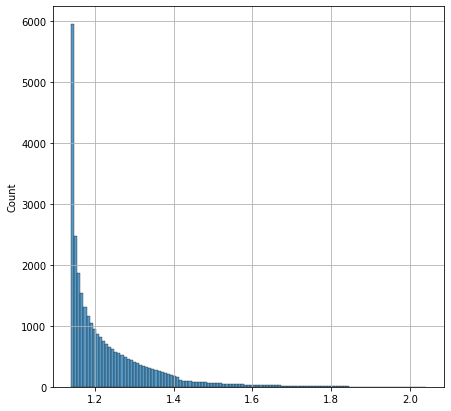

In [ ]:
plt.rcParams['figure.figsize'] = 7, 7
plt.rcParams.update({'font.size': 10})
plt.rc('lines', linewidth=4)
    
import seaborn as sns

m_s = np.arange(1, n)
cv_H_hat_normal = [get_H_hat_unbiased(X_normal_sort, int(m)) for m in m_s]

sns.histplot(cv_H_hat_normal)
plt.grid()
plt.show()

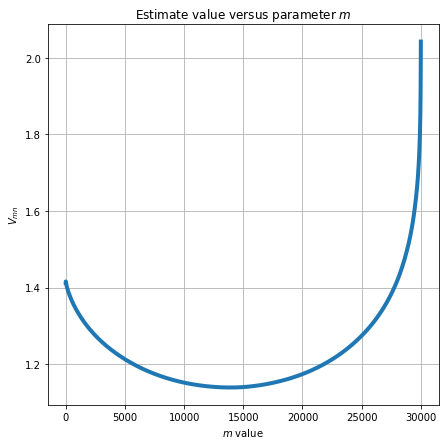

In [ ]:
plt.plot(cv_H_hat_normal)
plt.title(r"Estimate value versus parameter $m$")
plt.xlabel(r"$m$ value")
plt.ylabel(r"$V_{mn}$")
plt.grid()

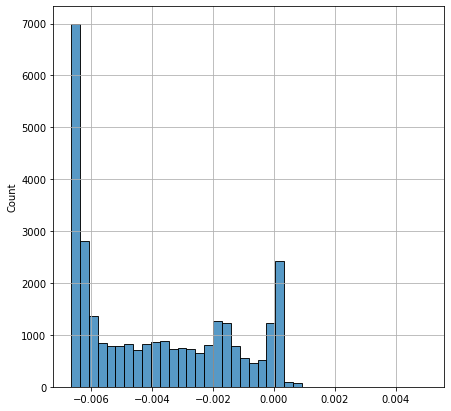

In [ ]:
m_s = np.arange(1, n)
cv_H_hat_uniform = [get_H_hat_unbiased(X_uniform_sort, int(m)) for m in m_s]

sns.histplot(cv_H_hat_uniform)
plt.grid()
plt.show()

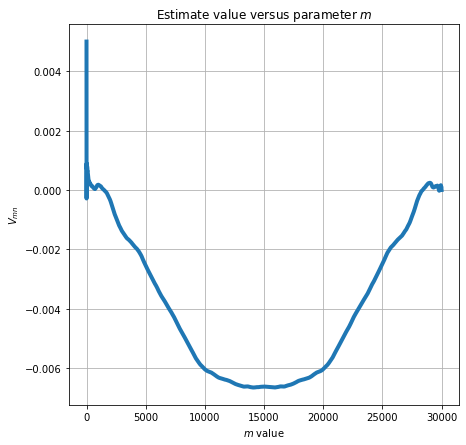

In [ ]:
plt.plot(cv_H_hat_uniform)
plt.title(r"Estimate value versus parameter $m$")
plt.xlabel(r"$m$ value")
plt.ylabel(r"$V_{mn}$")
plt.grid()
plt.show()

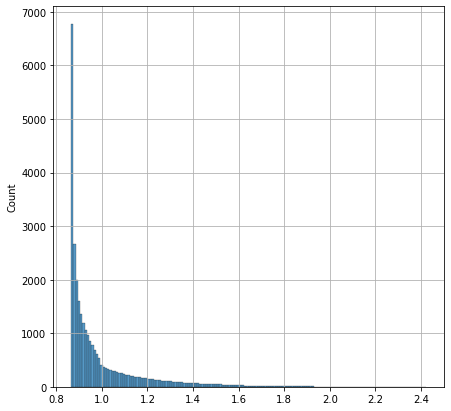

In [ ]:
m_s = np.arange(1, n)
cv_H_hat_exponential = [get_H_hat_unbiased(X_exponential_sort, int(m)) for m in m_s]

sns.histplot(cv_H_hat_exponential)
plt.grid()
plt.show()

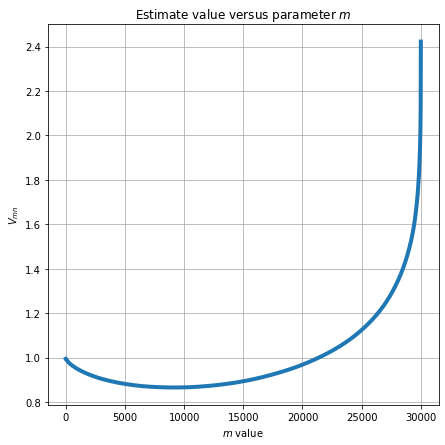

In [ ]:
plt.plot(cv_H_hat_exponential)
plt.title(r"Estimate value versus parameter $m$")
plt.xlabel(r"$m$ value")
plt.ylabel(r"$V_{mn}$")
plt.grid()
plt.show()

To achieve best estimation we need to take m small or approx n.

# Experiments on different distributions(hist & kernel)

In [ ]:
def get_hist_kernel_estimate_and_sigmas(samples, h_hist_list, h_kernel_list):

    cv_hist = [cross_val_hist(samples, hi)[0] for hi in h_hist_list]
    h_hist = h_hist_list[np.argmin(cv_hist)]

    cv_kernel = [cross_val_gaus(samples, hi) for hi in h_kernel_list]
    h_kernel = h_kernel_list[np.argmin(cv_kernel)]

    hist_densities = [get_density(s, i, h_hist, samples) for i, s in enumerate(samples)]
    
    hist_estimate = get_hist_estimate(samples, h_hist)
    hist_sigma = get_sigma(hist_densities, hist_estimate)

    kernel_densities = [get_density(s, i, h_kernel, samples) for i, s in enumerate(samples)]
    
    kernel_estimate = get_kernel_estimate(samples, h_kernel)
    kernel_sigma = get_sigma(kernel_densities, kernel_estimate)

    return (hist_estimate, hist_sigma), (kernel_estimate, kernel_sigma)

## 1) Estimates for every kind

In [ ]:
SIZE = 1000
dist_names = ['normal', 'normal', 'normal', 'uniform', 'uniform', 'uniform', 'exponential', 'exponential', 'exponential',
              'laplace', 'laplace', 'laplace', 'chisquare', 'chisquare', 'chisquare',  'gamma', 'gamma', 'gamma']
dist_list = [
             np.random.normal(size=SIZE),
             np.random.normal(0, 5, size=SIZE),
             np.random.normal(0, 30, size=SIZE),

             np.random.uniform(size=SIZE),
             np.random.uniform(0, 10, size=SIZE),
             np.random.uniform(5, 20, size=SIZE),

             np.random.exponential(size=SIZE),
             np.random.exponential(0.5, size=SIZE),
             np.random.exponential(0.1, size=SIZE),

             np.random.laplace(size=SIZE),
             np.random.laplace(scale=2, size=SIZE),
             np.random.laplace(scale=4, size=SIZE),

             np.random.chisquare(df=2, size=SIZE),
             np.random.chisquare(df=3, size=SIZE),
             np.random.chisquare(df=4, size=SIZE),

             np.random.gamma(2, 2, size=SIZE),
             np.random.gamma(3, 2, size=SIZE),
             np.random.gamma(3, 3, size=SIZE)
]

In [ ]:
h_hist_list = np.logspace(-1, 1, 100)
h_kernel_list = np.logspace(-1, 1, 10)

In [ ]:
params = [
          "mean = 0, std = 1",
          "mean = 0, std = 5",
          "mean = 0, std = 30",
          "a = 0, b = 1",
          "a = 0, b = 10",
          "a = 5, b = 20",
          "lambda = 1",
          "lambda = 2",
          "lambda = 10",
          "mean = 0.0, exponential decay = 1.0",
          "mean = 0.0, exponential decay = 2.0",
          "mean = 0.0, exponential decay = 4.0",
          "df = 2",
          "df = 3",
          "df = 4",
          "shape = 2, scale = 2",
          "shape = 3, scale = 2",
          "shape = 3, scale = 3"
]

In [ ]:
index = 0
import pandas as pd

df = pd.DataFrame(columns=['Distribution', "Parameters", 'Histogram estimate', 'Sigma histogram', 'Kernel estimate', 'Sigma kernel'])
for data, name in zip(estimates_list, dist_names):
    h_data, k_data = data
    hist, h_sigma = h_data
    kernel, k_sigma = k_data
    cur_row = np.array([name, params[index], -round(hist, 3), round(h_sigma, 3), -round(kernel, 3), round(k_sigma, 3)])
    df.loc[index] = cur_row

    print('\n{:-^30}'.format('['+ name.upper() + ']'))
    print('Hist:', \
      f'estimate: {-hist: >7.3f}', \
      f'sigma: {h_sigma: >10.3f}', \
      sep='\n')
    
    print('Kernel:', \
      f'estimate: {-kernel: >7.3f}', \
      f'sigma: {k_sigma: >10.3f}', \
      sep='\n')
    index += 1


## 2) Noised estimates with "white noise" for every kind

In [ ]:
noised_dist_list = [d + np.random.standard_normal(size=SIZE) for d in dist_list]

In [ ]:
df_1 = pd.DataFrame(columns=['Distribution', "Parameters", 'Histogram estimate', 'Sigma histogram', 'Kernel estimate', 'Sigma kernel'])
index = 0
for data, name in zip(noised_estimates_list, dist_names):
    h_data, k_data = data
    hist, h_sigma = h_data
    kernel, k_sigma = k_data
    cur_row = np.array([name, params[index], -round(hist, 3), round(h_sigma, 3), -round(kernel, 3), round(k_sigma, 3)])
    df_1.loc[index] = cur_row

    print('\n{:-^30}'.format('['+ name.upper() + ']'))

    print('Hist:', \
      f'estimate: {-hist: >7.3f}', \
      f'sigma: {h_sigma: >10.3f}', \
      sep='\n')
    
    print('Kernel:', \
      f'estimate: {-kernel: >7.3f}', \
      f'sigma: {k_sigma: >10.3f}', \
      sep='\n')
    index += 1

In [ ]:
import csv

Now let's compare the obtained estimates with the real entropy valeus.

In [ ]:
SIZE = 1000
dist_names = ['normal', 'normal', 'normal', 'uniform', 'uniform', 'uniform', 'exponential', 'exponential', 'exponential',
              'laplace', 'laplace', 'laplace', 'chisquare', 'chisquare', 'chisquare',  'gamma', 'gamma', 'gamma']
dist_list = [
             np.random.normal(size=SIZE),
             np.random.normal(0, 5, size=SIZE),
             np.random.normal(0, 30, size=SIZE),

             np.random.uniform(size=SIZE),
             np.random.uniform(0, 10, size=SIZE),
             np.random.uniform(5, 20, size=SIZE),

             np.random.exponential(size=SIZE),
             np.random.exponential(0.5, size=SIZE),
             np.random.exponential(0.1, size=SIZE),

             np.random.laplace(size=SIZE),
             np.random.laplace(scale=2, size=SIZE),
             np.random.laplace(scale=4, size=SIZE),

             np.random.chisquare(df=2, size=SIZE),
             np.random.chisquare(df=3, size=SIZE),
             np.random.chisquare(df=4, size=SIZE),

             np.random.gamma(2, 2, size=SIZE),
             np.random.gamma(3, 2, size=SIZE),
             np.random.gamma(3, 3, size=SIZE)
]

In [ ]:
from scipy.special import digamma, gamma

H_normal_1 = round(real_H_normal(1),3)
H_normal_2 = round(real_H_normal(5), 3)
H_normal_3 = round(real_H_normal(30), 3)

H_uniform_1 = round(real_H_uniform(0, 1), 3)
H_uniform_2 = round(real_H_uniform(0, 10), 3)
H_uniform_3 = round(real_H_uniform(5, 20), 3)

H_exponential_1 = round(real_H_exponential(1), 3)
H_exponential_2 = round(real_H_exponential(5), 3)
H_exponential_3 = round(real_H_exponential(10), 3)

H_laplace_1 = round(real_H_laplace(1), 3)
H_laplace_2 = round(real_H_laplace(2), 3)
H_laplace_3 = round(real_H_laplace(4), 3)

H_chisquare_1 = round(real_H_chi_squared(2), 3)
H_chisquare_2 = round(real_H_chi_squared(3), 3)
H_chisquare_3 = round(real_H_chi_squared(4), 3)

H_gamma_1 = round(real_H_gamma(2, 2), 3)
H_gamma_2 = round(real_H_gamma(3, 2), 3)
H_gamma_3 = round(real_H_gamma(3, 3), 3)

In [ ]:
real_Hs = [H_normal_1,
           H_normal_2,
           H_normal_3,
           H_uniform_1,
           H_uniform_2,
           H_uniform_3,
           H_exponential_1,
           H_exponential_2,
           H_exponential_3,
           H_laplace_1,
           H_laplace_2,
           H_laplace_3,
           H_chisquare_1,
           H_chisquare_2,
           H_chisquare_3,
           H_gamma_1,
           H_gamma_2,
           H_gamma_3
]

In [ ]:
data = pd.read_csv('/content/estims-2.uu')
data['Real H'] = real_Hs

,Distribution,Parameters,Histogram estimate,Sigma histogram,Kernel estimate,Sigma kernel,Real H
0,normal,"mean = 0, std = 1",1.360,0.640,1.388,0.637,1.419
1,normal,"mean = 0, std = 5",2.971,0.661,2.996,0.661,3.028
2,normal,"mean = 0, std = 30",4.773,0.420,4.834,0.422,4.820
3,uniform,"a = 0, b = 1",-0.007,0.163,0.100,0.155,0.000
4,uniform,"a = 0, b = 5",2.289,0.715,2.324,0.722,2.303
5,uniform,"a = 5, b = 20",2.701,0.659,2.723,0.691,2.708
6,exponential,lambda = 1,0.942,0.523,1.048,0.505,1.000
7,exponential,lambda = 2,0.211,0.356,0.339,0.394,-0.609
8,exponential,lambda = 10,-1.276,1.669,-0.855,1.670,-1.303
9,laplace,"mean = 0.0, exponential decay = 1.0",1.677,0.651,2.333,0.637,1.693


In [ ]:
noised_data = pd.read_csv('/content/noised_estims')
noised_data['Real H'] = real_Hs

,Distribution,Parameters,Histogram estimate,Sigma histogram,Kernel estimate,Sigma kernel,Real H
0,normal,"mean = 0, std = 1",1.771,0.704,1.788,0.701,1.419
1,normal,"mean = 0, std = 5",2.980,0.658,3.014,0.659,3.028
2,normal,"mean = 0, std = 30",4.769,0.419,4.806,0.418,4.820
3,uniform,"a = 0, b = 1",1.421,0.669,1.432,0.654,0.000
4,uniform,"a = 0, b = 5",2.426,0.708,2.491,0.708,2.303
5,uniform,"a = 5, b = 20",2.814,0.679,2.835,0.680,2.708
6,exponential,lambda = 1,1.692,0.700,1.727,0.689,1.000
7,exponential,lambda = 2,1.514,0.674,1.541,0.669,-0.609
8,exponential,lambda = 10,1.381,0.654,1.416,0.651,-1.303
9,laplace,"mean = 0.0, exponential decay = 1.0",1.933,0.697,2.005,0.695,1.693


From the above we can see, that our estimates perform really well for all types of distributions. For all families (besides normal one) histogram estimate gives us a better approximation to a real value. For normal one kernel performs better which can be connected with the fact that we used Gaussian kernel in this case.

On the other hand, noising the distributions breaks the estimate in the most cases. Estimates are alright just for gamma distribution and normal distribution. That most likely happens because the noise distribution is normal, hence it doesn't break the structure of the initial sample really hard.

# Experiments with normal distribution using spacings estimate.

For each experience I took parameter m small, because we investigated it earlier.

## Experiment 1 : different means

In [ ]:
n = 30000
X_normal_0 = np.random.normal(0, 3, n)
X_normal_p3 = np.random.normal(3, 3, n)
X_normal_m3 = np.random.normal(-3, 3, n)
X_normal_p10 = np.random.normal(10, 3, n)
X_normal_m10 = np.random.normal(-10, 3, n)

In [ ]:
print(f"For normal distribution with std = 3 H value equals {real_H_normal(3):.4f}")
print("---------------------------------")
print(f"For sample with mean {0} estimate is {get_H_hat_unbiased(np.sort(X_normal_0), 10):.4f}")
print(f"For sample with mean {3} estimate is {get_H_hat_unbiased(np.sort(X_normal_p3), 10):.4f}")
print(f"For sample with mean {-3} estimate is {get_H_hat_unbiased(np.sort(X_normal_m3), 10):.4f}")
print(f"For sample with mean {10} estimate is {get_H_hat_unbiased(np.sort(X_normal_p10), 10):.4f}")
print(f"For sample with mean {-10} estimate is {get_H_hat_unbiased(np.sort(X_normal_m10), 10):.4f}")

For normal distribution with std = 3 H value equals 2.5176
---------------------------------
For sample with mean 0 estimate is 2.5159
For sample with mean 3 estimate is 2.5134
For sample with mean -3 estimate is 2.5130
For sample with mean 10 estimate is 2.5112
For sample with mean -10 estimate is 2.5142


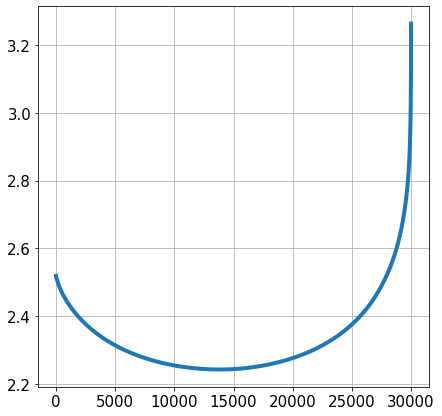

In [ ]:
plt.rcParams['figure.figsize'] = 7, 7
plt.rcParams.update({'font.size': 15})
plt.rc('lines', linewidth=4)

import seaborn as sns

m_s = np.arange(1, n)
cv_H_hat_normal = [get_H_hat_unbiased(np.sort(X_normal_0), m) for m in m_s]

plt.plot(cv_H_hat_normal)
plt.grid()
plt.show()

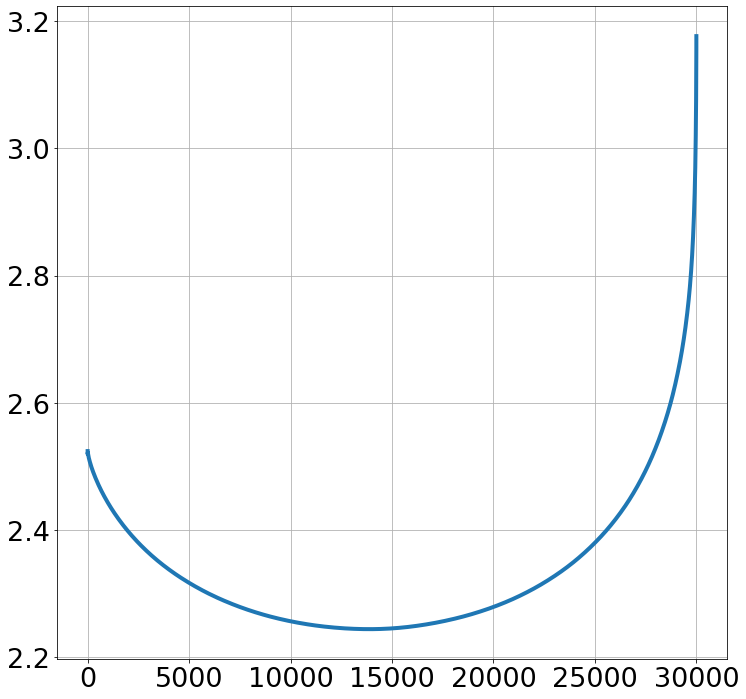

In [ ]:
m_s = np.arange(1, n)
cv_H_hat_normal = [get_H_hat_unbiased(np.sort(X_normal_p3), m) for m in m_s]

plt.plot(cv_H_hat_normal)
plt.grid()
plt.show()

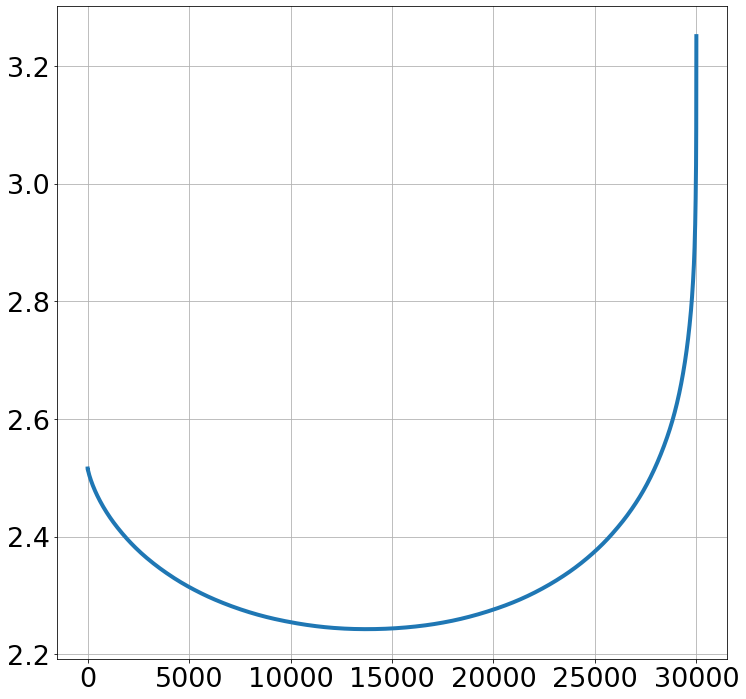

In [ ]:
m_s = np.arange(1, n)
cv_H_hat_normal = [get_H_hat_unbiased(np.sort(X_normal_m3), m) for m in m_s]

plt.plot(cv_H_hat_normal)
plt.grid()
plt.show()

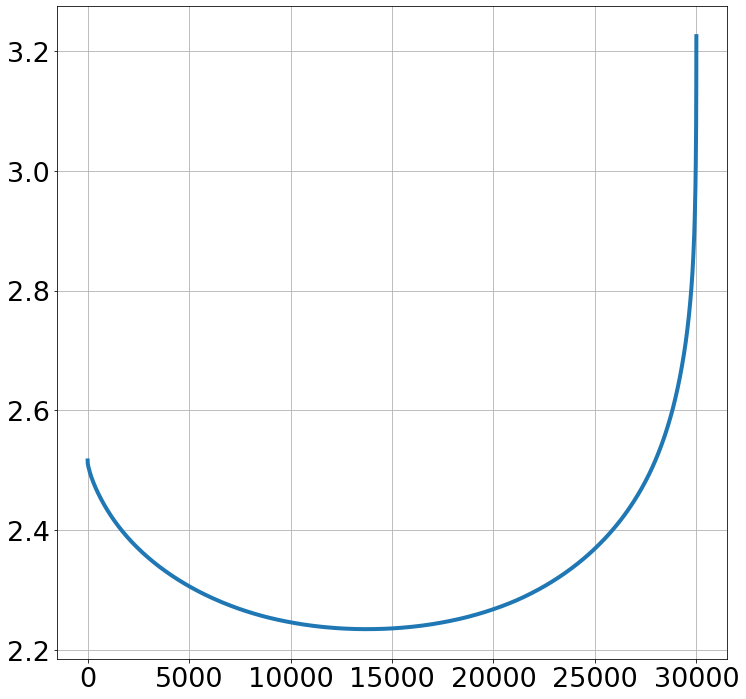

In [ ]:
m_s = np.arange(1, n)
cv_H_hat_normal = [get_H_hat_unbiased(np.sort(X_normal_p10), m) for m in m_s]

plt.plot(cv_H_hat_normal)
plt.grid()
plt.show()

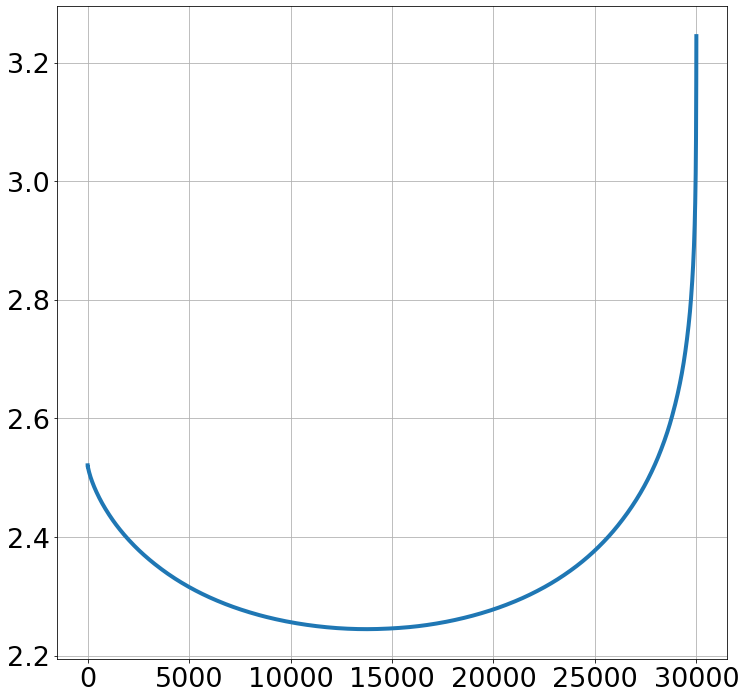

In [ ]:
m_s = np.arange(1, n)
cv_H_hat_normal = [get_H_hat_unbiased(np.sort(X_normal_m10), m) for m in m_s]

plt.plot(cv_H_hat_normal)
plt.grid()
plt.show()

This experiment shows us that different mean does not change spacing estimate.

## Experiment 2 : different vars

In [ ]:
n = 30000
X_normal_1 = np.random.normal(0, 1, n)
X_normal_5 = np.random.normal(0, 5, n)
X_normal_10 = np.random.normal(0, 10, n)
X_normal_20 = np.random.normal(0, 20, n)
X_normal_50 = np.random.normal(0, 50, n)

In [ ]:
print("---------------------------------")
print(f"For sample with std {1} estimate is {get_H_hat_unbiased(np.sort(X_normal_1), 10):.4f}")
print(f"For normal distribution with std = 1 H value equals {real_H_normal(1):.4f}")
print("---------------------------------")
print(f"For sample with std {5} estimate is {get_H_hat_unbiased(np.sort(X_normal_5), 10):.4f}")
print(f"For normal distribution with std = 5 H value equals {real_H_normal(5):.4f}")
print("---------------------------------")
print(f"For sample with std {10} estimate is {get_H_hat_unbiased(np.sort(X_normal_10), 10):.4f}")
print(f"For normal distribution with std = 10 H value equals {real_H_normal(10):.4f}")
print("---------------------------------")
print(f"For sample with std {20} estimate is {get_H_hat_unbiased(np.sort(X_normal_20), 10):.4f}")
print(f"For normal distribution with std = 20 H value equals {real_H_normal(20):.4f}")
print("---------------------------------")
print(f"For sample with std {50} estimate is {get_H_hat_unbiased(np.sort(X_normal_50), 10):.4f}")
print(f"For normal distribution with std = 50 H value equals {real_H_normal(50):.4f}")

---------------------------------
For sample with std 1 estimate is 1.4222
For normal distribution with std = 1 H value equals 1.4189
---------------------------------
For sample with std 5 estimate is 3.0225
For normal distribution with std = 5 H value equals 3.0284
---------------------------------
For sample with std 10 estimate is 3.7188
For normal distribution with std = 10 H value equals 3.7215
---------------------------------
For sample with std 20 estimate is 4.4128
For normal distribution with std = 20 H value equals 4.4147
---------------------------------
For sample with std 50 estimate is 5.3303
For normal distribution with std = 50 H value equals 5.3310


We can see that for any sigma this method gives us good estimate.

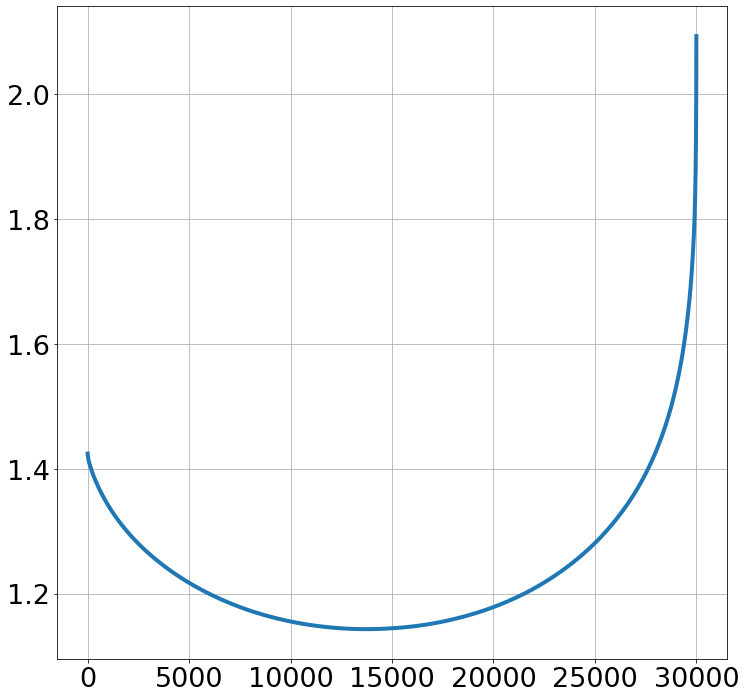

In [ ]:
m_s = np.arange(1, n)
cv_H_hat_normal = [get_H_hat_unbiased(np.sort(X_normal_1), m) for m in m_s]

plt.plot(cv_H_hat_normal)
plt.grid()
plt.show()

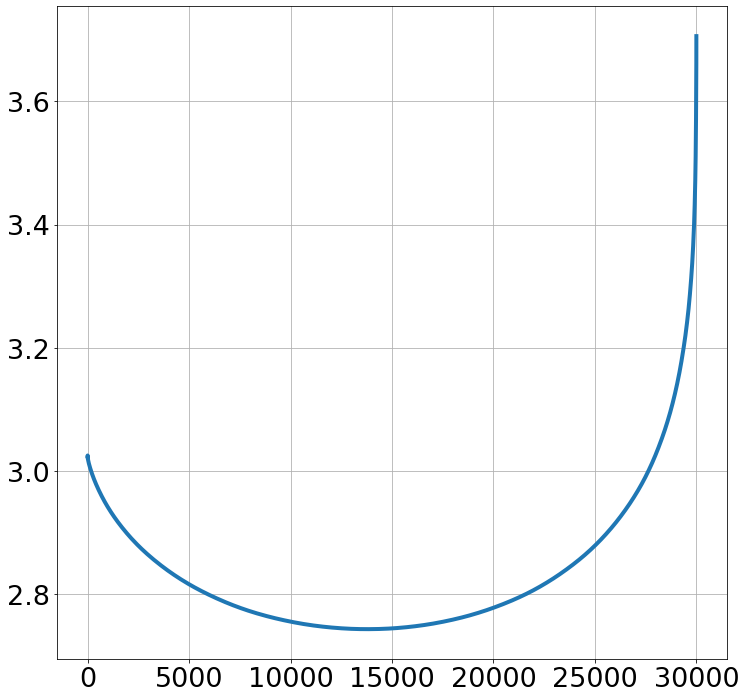

In [ ]:
m_s = np.arange(1, n)
cv_H_hat_normal = [get_H_hat_unbiased(np.sort(X_normal_5), m) for m in m_s]

plt.plot(cv_H_hat_normal)
plt.grid()
plt.show()

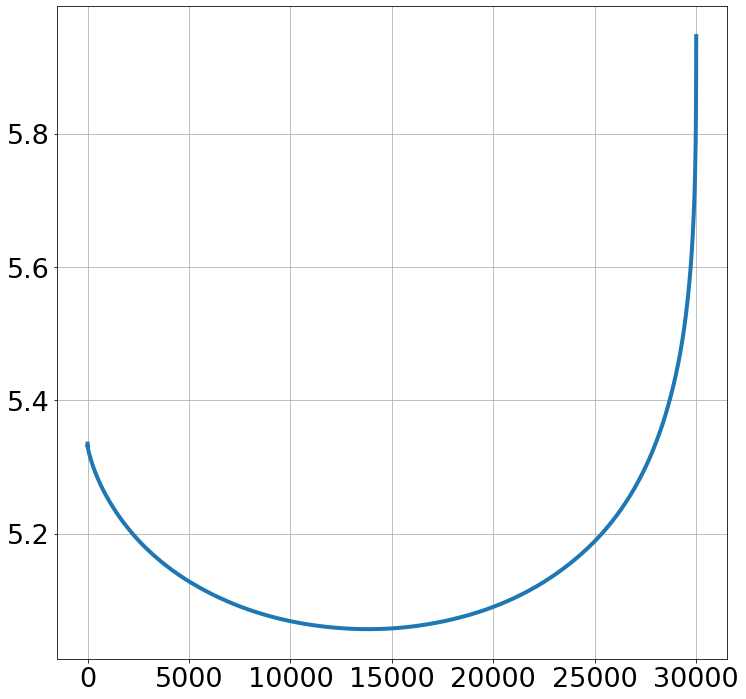

In [ ]:
m_s = np.arange(1, n)
cv_H_hat_normal = [get_H_hat_unbiased(np.sort(X_normal_50), m) for m in m_s]

plt.plot(cv_H_hat_normal)
plt.grid()
plt.show()

## Experiment 3. Different distributions.

In [ ]:
SIZE = 30000
dist_names = ['normal', 'normal', 'normal', 'uniform', 'uniform', 'uniform', 'exponential', 'exponential', 'exponential',
              'laplace', 'laplace', 'laplace', 'chisquare', 'chisquare', 'chisquare',  'gamma', 'gamma', 'gamma']
dist_list = [
             np.random.normal(size=SIZE),
             np.random.normal(0, 5, size=SIZE),
             np.random.normal(0, 30, size=SIZE),

             np.random.uniform(size=SIZE),
             np.random.uniform(0, 10, size=SIZE),
             np.random.uniform(5, 20, size=SIZE),

             np.random.exponential(size=SIZE),
             np.random.exponential(0.5, size=SIZE),
             np.random.exponential(0.1, size=SIZE),

             np.random.laplace(size=SIZE),
             np.random.laplace(scale=2, size=SIZE),
             np.random.laplace(scale=4, size=SIZE),

             np.random.chisquare(df=2, size=SIZE),
             np.random.chisquare(df=3, size=SIZE),
             np.random.chisquare(df=4, size=SIZE),

             np.random.gamma(2, 2, size=SIZE),
             np.random.gamma(3, 2, size=SIZE),
             np.random.gamma(3, 3, size=SIZE)
]

params = [
          "mean = 0, std = 1",
          "mean = 0, std = 5",
          "mean = 0, std = 30",
          "a = 0, b = 1",
          "a = 0, b = 10",
          "a = 5, b = 20",
          "lambda = 1",
          "lambda = 2",
          "lambda = 10",
          "mean = 0.0, exponential decay = 1.0",
          "mean = 0.0, exponential decay = 2.0",
          "mean = 0.0, exponential decay = 4.0",
          "df = 2",
          "df = 3",
          "df = 4",
          "shape = 2, scale = 2",
          "shape = 3, scale = 2",
          "shape = 3, scale = 3"
]

grounds = [real_H_normal(1), 
           real_H_normal(5),
           real_H_normal(30),
           real_H_uniform(0, 1),
           real_H_uniform(0, 10),
           real_H_uniform(5, 20),
           real_H_exponential(1),
           real_H_exponential(2),
           real_H_exponential(10),
           real_H_laplace(1),
           real_H_laplace(2),
           real_H_laplace(4),
           real_H_chi_squared(2),
           real_H_chi_squared(3),
           real_H_chi_squared(4),
           real_H_gamma(2, 2),
           real_H_gamma(2, 3),
           real_H_gamma(3, 3)
           ]


In [ ]:
estims = [get_H_hat_unbiased(np.sort(dist), 10) for dist in dist_list]
#estims_1 = [get_H_hat_unbiased(np.sort(dist), 10) for dist in dist_list]

In [ ]:
index = 0
import pandas as pd

df = pd.DataFrame(columns=['Distribution', "Parameters", 'Estimate (n=30000)', 'Estimate (n=1000)', 'Real Value'])
for data, est1, name, ground in zip(estims, estims_1, dist_names, grounds):
    cur_row = np.array([name, params[index], round(data, 3), round(est1, 3), round(ground, 3)])
    df.loc[index] = cur_row
    index += 1

In [ ]:
df

,Distribution,Parameters,Estimate (n=30000),Estimate (n=1000),Real Value
0,normal,"mean = 0, std = 1",1.416,4.729,1.419
1,normal,"mean = 0, std = 5",3.023,6.349,3.028
2,normal,"mean = 0, std = 30",4.816,8.161,4.82
3,uniform,"a = 0, b = 1",-0.001,3.396,0.0
4,uniform,"a = 0, b = 10",2.302,5.702,2.303
5,uniform,"a = 5, b = 20",2.71,6.111,2.708
6,exponential,lambda = 1,1.003,4.363,1.0
7,exponential,lambda = 2,0.297,3.728,0.307
8,exponential,lambda = 10,-1.307,2.033,-1.303
9,laplace,"mean = 0.0, exponential decay = 1.0",1.686,4.998,1.693


For almost all distributions given method works very good only with big sample size, and only for Chi-square distribution with df = 4 sparcings estimate shows very biased result. 

So now compare this estimate with previous ones.

In [ ]:
data = pd.read_csv('/content/estims-2.uu')
data['Real H'] = real_Hs
data["Spacings estimate (1000)"] = estims_1
data["Spacings estimate (30000)"] = estims
data

,Distribution,Parameters,Histogram estimate,Sigma histogram,Kernel estimate,Sigma kernel,Real H,Spacings estimate (1000),Spacings estimate (30000)
0,normal,"mean = 0, std = 1",1.360,0.640,1.388,0.637,1.419,4.728675,1.415909
1,normal,"mean = 0, std = 5",2.971,0.661,2.996,0.661,3.028,6.349098,3.022683
2,normal,"mean = 0, std = 30",4.773,0.420,4.834,0.422,4.820,8.160778,4.816107
3,uniform,"a = 0, b = 1",-0.007,0.163,0.100,0.155,0.000,3.395553,-0.000983
4,uniform,"a = 0, b = 5",2.289,0.715,2.324,0.722,2.303,5.701646,2.301599
5,uniform,"a = 5, b = 20",2.701,0.659,2.723,0.691,2.708,6.110947,2.709855
6,exponential,lambda = 1,0.942,0.523,1.048,0.505,1.000,4.362730,1.002654
7,exponential,lambda = 2,0.211,0.356,0.339,0.394,-0.609,3.728439,0.297170
8,exponential,lambda = 10,-1.276,1.669,-0.855,1.670,-1.303,2.033251,-1.306775
9,laplace,"mean = 0.0, exponential decay = 1.0",1.677,0.651,2.333,0.637,1.693,4.998414,1.685812


We can see, that estimate based on spacings gives us best approximation with big sample size. But if compare with n = 1000, kernel and histogram estimates shows very good result.

# Experimential approach to estimate entropy using k-ordered statistic.

[A new class of random vector entropy estimators and its applications in testing statistical hypotheses(2003)](https://www.tandfonline.com/doi/pdf/10.1080/104852504200026815?needAccess=true)

$H_{k}^n = \frac{p}{n}\sum_{i=1}^{n} ln(R_{i,k,n}) + ln(\frac{\pi^{p/2}}{Г(p/2 + 1)} - \psi(k) + ln(n)$

$H_{k, N}=p \ln \bar{\rho}_{k}+\ln (N-1)-\psi(k)+\ln c(p)$

$\rho(x,y) = \sqrt{\sum_{i}^m (x_i - y_i})$ 

$\psi(z)=\frac{\Gamma^{\prime}(z)}{\Gamma(z)} \approx ln(x) - \frac{1}{2x}$. Digamma function

$c(p)={2 \pi^{p / 2} \over p \Gamma(p / 2)}$

$\bar{\rho}_{k}=$ Geometric mean of $\rho(1, k), \ldots, \rho(N, k)$

$\rho_{i, k}=\min \left\{\rho\left(\mathbf{X}_{i}, \mathbf{X}_{j}\right), j \in\{1,2, \ldots, N\} \backslash\left\{i, j_{1}, \ldots, j_{k-1}\right\}\right\}=\rho\left(\mathbf{X}_{i}, \mathbf{X}_{j_{k}}\right)$

In [ ]:
n = 1000
X_normal = np.random.normal(0, 1, n)
X_uniform = np.random.uniform(0, 1, n)
X_exponential = np.random.exponential(1, n)

In [ ]:
from tqdm import tqdm 

plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
def distance(x1, x2):
    return np.abs(x1 - x2)

def calc_mean_distance(X, k):
    n = X.shape[0]
    idx, idy = np.meshgrid(X, X)
    distance_matrix =  np.abs(idx - idy)
    
    k_ordered_stat = np.sort(distance_matrix, axis=1)[:, k]
    log_average = np.sum(np.log(k_ordered_stat)) / n

    return np.exp(log_average)


In [ ]:
from scipy.special import digamma, gamma
p = 1.0
k = 25

def get_statistic(X, k, p):
    p_dist = p * calc_mean_distance(X, k)
    log_N_1 = np.log(X.shape[0] - 1)
    digamma_k = digamma(k)
    log_c = np.log(np.pi ** (p / 2.0) / (gamma(1 + p / 2.0)))

    statistic = p_dist + log_N_1 - digamma_k + log_c
    return statistic

print(f"H_k,N estimation for N(0, 1) is {get_statistic(X_normal, k, p):.4f}")
print(f"H_k,N estimation for U(0, 1) is {get_statistic(X_uniform, k, p):.4f}")
print(f"H_k,N estimation for Exp(0, 1) is {get_statistic(X_exponential, k, p):.4f}")

H_k,N estimation for N(0, 1) is 4.4495
H_k,N estimation for U(0, 1) is 4.4136
H_k,N estimation for Exp(0, 1) is 4.4350


100%|██████████| 998/998 [00:59<00:00, 16.75it/s]


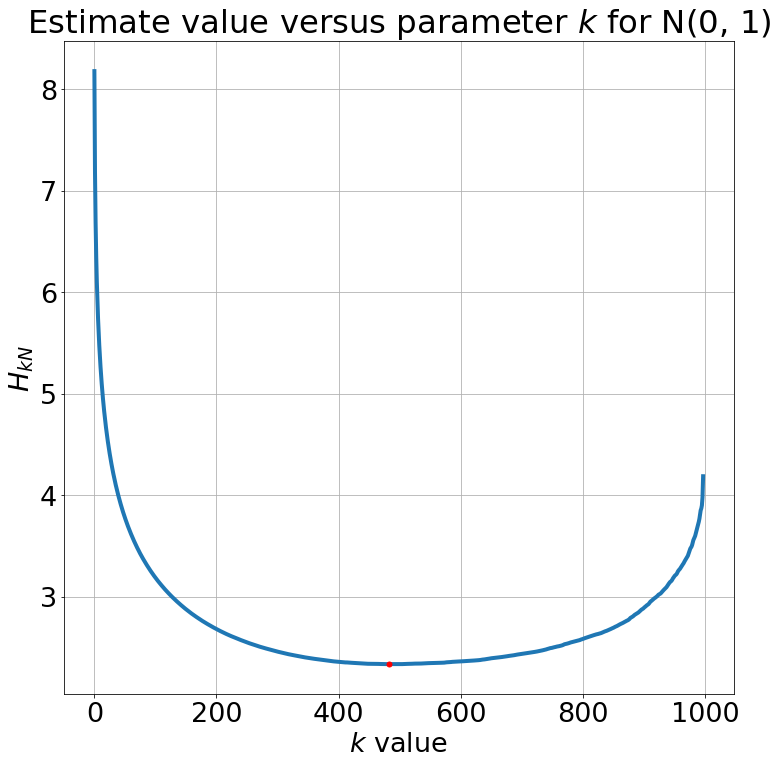

In [ ]:
stats = []
for k in tqdm(range(1, n - 1)):
    stats.append(get_statistic(X_normal, k, p))

plt.plot(stats)

plt.plot(np.argmin(stats), np.min(stats), 'ro', markersize='5')
plt.title(r"Estimate value versus parameter $k$ for N(0, 1)")
plt.xlabel(r"$k$ value")
plt.ylabel(r"$H_{kN}$")
plt.savefig("lupa.png")
plt.grid()
plt.show()

100%|██████████| 998/998 [00:59<00:00, 16.69it/s]


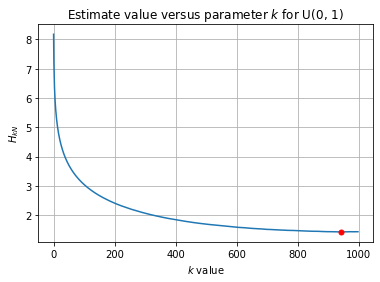

In [ ]:
stats = []
for k in tqdm(range(1, n - 1)):
    stats.append(get_statistic(X_uniform, k, p))

plt.plot(stats)

plt.plot(np.argmin(stats), np.min(stats), 'ro', markersize='5')
plt.title(r"Estimate value versus parameter $k$ for U(0, 1)")
plt.xlabel(r"$k$ value")
plt.ylabel(r"$H_{kN}$")
plt.grid()
plt.show()

100%|██████████| 998/998 [00:59<00:00, 16.71it/s]


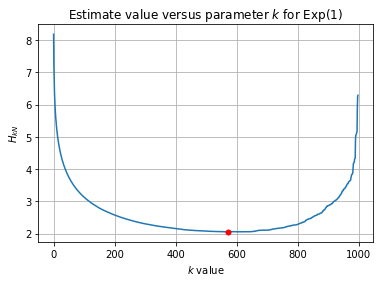

In [ ]:
stats = []
for k in tqdm(range(1, n - 1)):
    stats.append(get_statistic(X_exponential, k, p))

plt.plot(stats)

plt.plot(np.argmin(stats), np.min(stats), 'ro', markersize='5')
plt.title(r"Estimate value versus parameter $k$ for Exp(1)")
plt.xlabel(r"$k$ value")
plt.ylabel(r"$H_{kN}$")
plt.grid()
plt.show()

There is a problem with this estimate. It should be unbiased under some conditions, but we can see that it isn't. This conditions can easily be checked theoretically, but on practice we have too wide range of parameters, so we just can take a look on the graphs. Sadly, but we've decided not to compare this result with other estimates.